In [3]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

from global_land_mask import is_land
from matplotlib.colors import BoundaryNorm

from config import KSCALEOUTDIR
from read_data import *
from p_config import regions

In [4]:
### FUNC ###

def compute_ef(lhdata, shdata):
    """Compute evaporative fraction"""
    ef = lhdata / (lhdata + shdata)
    ef = ef.where((lhdata >= 0.) & (shdata >= 0.))  # compute EF only with both fluxes towards the atmosphere
    out = ef.where((ef >= 0.) & (ef <= 1.))

    return out

In [ ]:
#~ Outdir

if season == 'summer':
    path_season = 'outdir_20160801T0000Z'
elif season == 'winter':
    path_season = 'outdir_20200120T0000Z'

if not os.path.isdir(KSCALEOUTDIR + '/' + path_season):
    os.mkdir(KSCALEOUTDIR + '/' + path_season)
outdir = KSCALEOUTDIR + '/' + path_season

if not os.path.isdir(outdir + '/ef'):
    os.mkdir(outdir + '/ef')
outdir = outdir + '/ef'

if not os.path.isdir(outdir + '/DMn1280' + driving):
    os.mkdir(outdir + '/DMn1280' + driving)
outdir = outdir + '/DMn1280' + driving

if not os.path.isdir(outdir + '/global_' + res_glo + '_' + phy_glo):
    os.mkdir(outdir + '/global_' + res_glo + '_' + phy_glo)
outdir_glo = outdir + '/global_' + res_glo + '_' + phy_glo

if not os.path.isdir(outdir + '/channel_' + res_cha + '_' + physics):
    os.mkdir(outdir + '/channel_' + res_cha + '_' + physics)
outdir_cha = outdir + '/channel_' + res_cha + '_' + physics

if not os.path.isdir(outdir + '/lam_' + res_lam + '_' + physics):
    os.mkdir(outdir + '/lam_' + res_lam + '_' + physics)
outdir_lam = outdir + '/lam_' + res_lam + '_' + physics


print('Output directories:\n%s \n%s \n%s'%(outdir_glo, outdir_cha, outdir_lam))

In [ ]:
season='winter'
driving='GAL9'
res_glo = 'n1280'
phy_glo = 'GAL9'
res_cha='km4p4'
res_lam='km2p2'
region='africa'
physics='RAL3'

year = 2020
dates = {2: np.arange(1, 28+1, 1)}   # 1: np.arange(20, 30+1, 1)

lat_range = regions[region][0]
lon_range = regions[region][1]
lat_min = lat_range[0]
lat_max = lat_range[1]
lon_min = lon_range[0]
lon_max = lon_range[1]

In [7]:
#~ Get data

out_lh_glo = []
out_sh_glo = []
out_lh_cha = []
out_sh_cha = []
out_lh_lam = []
out_sh_lam = []

for month, days in dates.items():
    print('\no %i'%month)
    for day in days:
        print(day, end=' : ', flush=True)
        lh_glo = load_data_global_single_var(season, driving, res_glo, phy_glo, 'lhfx', year, month, day, (lat_min, lat_max), (lon_min, lon_max))
        sh_glo = load_data_global_single_var(season, driving, res_glo, phy_glo, 'shfx', year, month, day, (lat_min, lat_max), (lon_min, lon_max))
        lh_cha = load_data_channel_single_var(season, driving, res_cha, physics, 'lhfx', year, month, day, (lat_min, lat_max), (lon_min, lon_max))
        sh_cha = load_data_channel_single_var(season, driving, res_cha, physics, 'shfx', year, month, day, (lat_min, lat_max), (lon_min, lon_max))
        lh_lam = load_data_lam_single_var(season, driving, region, res_lam, physics, 'lhfx', year, month, day, (lat_min, lat_max), (lon_min, lon_max))
        sh_lam = load_data_lam_single_var(season, driving, region, res_lam, physics, 'shfx', year, month, day, (lat_min, lat_max), (lon_min, lon_max))

        out_lh_glo.append(lh_glo)
        out_sh_glo.append(sh_glo)
        out_lh_cha.append(lh_cha)
        out_sh_cha.append(sh_cha)
        out_lh_lam.append(lh_lam)
        out_sh_lam.append(sh_lam)
        #sys.exit()

out_lh_glo = xr.concat(out_lh_glo, dim='time')
out_sh_glo = xr.concat(out_sh_glo, dim='time')
out_lh_cha = xr.concat(out_lh_cha, dim='time')
out_sh_cha = xr.concat(out_sh_cha, dim='time')
out_lh_lam = xr.concat(out_lh_lam, dim='time')
out_sh_lam = xr.concat(out_sh_lam, dim='time')


o 2
1 : 2 : 3 : 4 : 5 : 6 : 7 : 8 : 9 : 10 : 11 : 12 : 13 : 14 : 15 : 16 : 17 : 18 : 19 : 20 : 21 : 22 : 23 : 24 : 25 : 26 : 27 : 28 : 

In [8]:
#~ Get daily data

out_lh_glo_d = out_lh_glo.resample(time='1D').mean()
out_sh_glo_d = out_sh_glo.resample(time='1D').mean()
out_lh_cha_d = out_lh_cha.resample(time='1D').mean()
out_sh_cha_d = out_sh_cha.resample(time='1D').mean()
out_lh_lam_d = out_lh_lam.resample(time='1D').mean()
out_sh_lam_d = out_sh_lam.resample(time='1D').mean()

In [9]:
#~ Mask ocean

lats = out_lh_glo_d.latitude.values
lons = out_lh_glo_d.longitude.values
lons_, lats_ = np.meshgrid(lons, lats)
land_mask = is_land(lats_, lons_)

out_lh_glo_d_land = out_lh_glo_d.where(land_mask)
out_sh_glo_d_land = out_sh_glo_d.where(land_mask)
out_lh_cha_d_land = out_lh_cha_d.where(land_mask)
out_sh_cha_d_land = out_sh_cha_d.where(land_mask)
out_lh_lam_d_land = out_lh_lam_d.where(land_mask)
out_sh_lam_d_land = out_sh_lam_d.where(land_mask)

In [13]:
#~ Compute EF

ef_glo = compute_ef(out_lh_glo_d_land, out_sh_glo_d_land)
ef_cha = compute_ef(out_lh_cha_d_land, out_sh_cha_d_land)
ef_lam = compute_ef(out_lh_lam_d_land, out_sh_lam_d_land)

In [24]:
#~ Save

outfile_glo = outdir_glo + '/ef_daily.nc'
ef_glo.to_netcdf(outfile_glo)
outfile_cha = outdir_cha + '/ef_daily.nc'
ef_cha.to_netcdf(outfile_cha)
outfile_lam = outdir_lam + '/ef_daily.nc'
ef_lam.to_netcdf(outfile_lam)

Output directories:
/home/users/guicha/Pythons/KSCALE/outputs/data/ef/DMn1280GAL9/global_n1280_GAL9 
/home/users/guicha/Pythons/KSCALE/outputs/data/ef/DMn1280GAL9/channel_km4p4_RAL3 
/home/users/guicha/Pythons/KSCALE/outputs/data/ef/DMn1280GAL9/lam_km2p2_RAL3


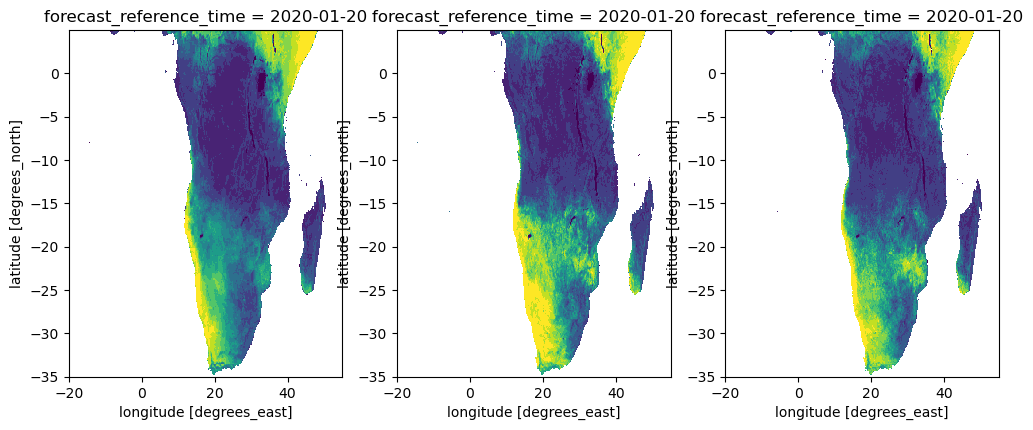

In [22]:
#~ Plot maps of EF

ef_glo_mean = ef_glo.mean(dim='time')
ef_cha_mean = ef_cha.mean(dim='time')
ef_lam_mean = ef_lam.mean(dim='time')


fig, ax = plt.subplots(ncols=3)

cmap = plt.get_cmap('viridis_r')
bounds = np.linspace(0., 1., 13)
norm = BoundaryNorm(bounds, cmap.N)

ef_glo_mean.plot(ax=ax[0], norm=norm, cmap=cmap, add_colorbar=False)
ef_cha_mean.plot(ax=ax[1], norm=norm, cmap=cmap, add_colorbar=False)
ef_lam_mean.plot(ax=ax[2], norm=norm, cmap=cmap, add_colorbar=False)

fig.set_size_inches(12., 4.5)